# Домашнее задание по теме «Ансамблирование» обновленное


In [1]:
!unzip archive.zip

Archive:  archive.zip
  inflating: heart.csv               


In [97]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [16]:
warnings.filterwarnings('ignore')

In [36]:
data = pd.read_csv('heart.csv')

In [37]:
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Проверим данные на пропуски

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Посмотрим на статистику

In [39]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Посмотрим на перекос целевой переменной

In [40]:
data['HeartDisease'].value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

Посмотрим на уникальные значения для категориальных признаков

In [41]:
cat_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
for feature in cat_features:
    print(feature, data[feature].unique())

Sex ['M' 'F']
ChestPainType ['ATA' 'NAP' 'ASY' 'TA']
RestingECG ['Normal' 'ST' 'LVH']
ExerciseAngina ['N' 'Y']
ST_Slope ['Up' 'Flat' 'Down']


Построим диаграммы распределения числовых переменных на предмет потенциальных выбросов и отклонений.
Признак `FastingBS` не учитываем, т.к. он категориальный.



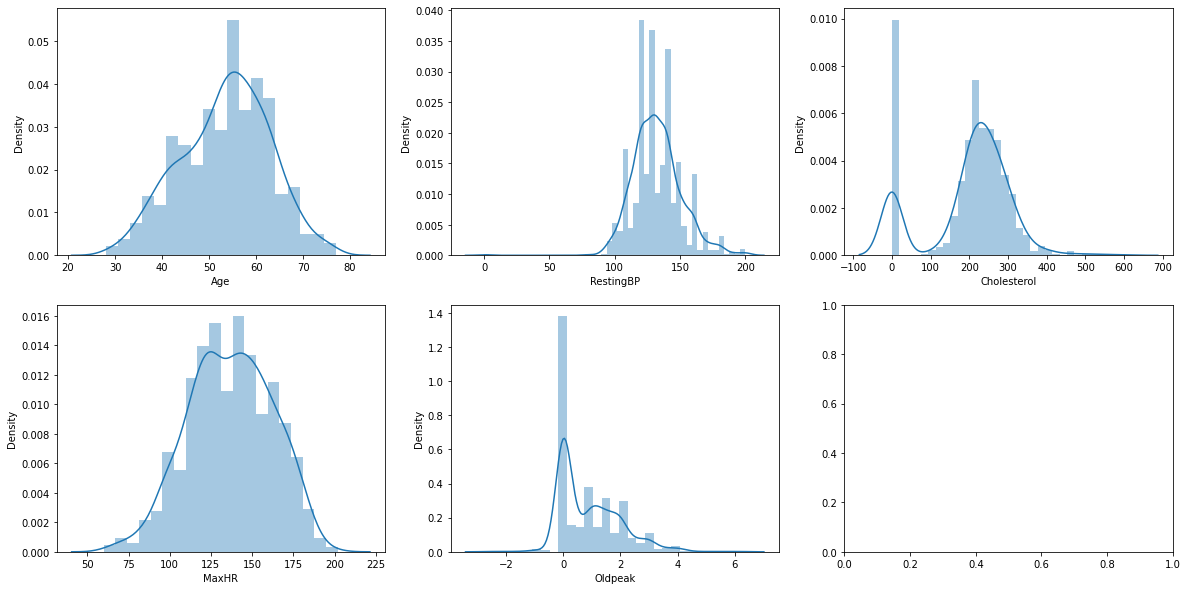

In [19]:
plt.rcParams['figure.figsize'] = 20, 10
fig, axs = plt.subplots(2,3)

sns.distplot(data['Age'], ax = axs[0,0])
sns.distplot(data['RestingBP'], ax = axs[0,1])
sns.distplot(data['Cholesterol'], ax = axs[0,2])
sns.distplot(data['MaxHR'], ax = axs[1,0])
sns.distplot(data['Oldpeak'], ax = axs[1,1])


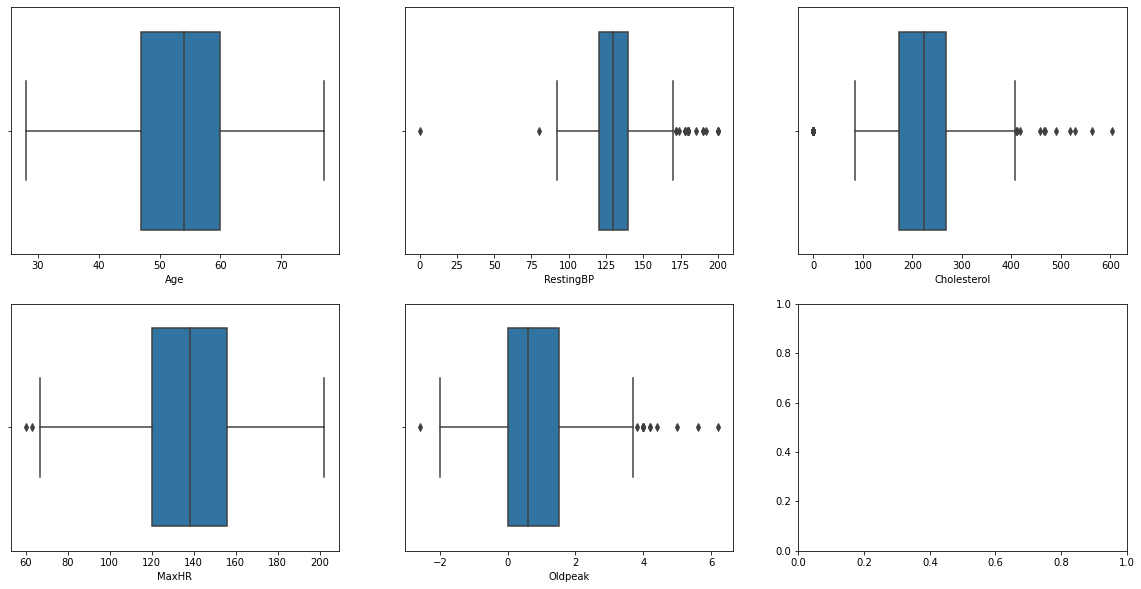

In [20]:
fig, axs = plt.subplots(2,3)

sns.boxplot(data['Age'], ax = axs[0,0])
sns.boxplot(data['RestingBP'], ax = axs[0,1])
sns.boxplot(data['Cholesterol'], ax = axs[0,2])
sns.boxplot(data['MaxHR'], ax = axs[1,0])
sns.boxplot(data['Oldpeak'], ax = axs[1,1])


`RestingBP` (артериальное давление в покое) не может быть равно 0.

In [21]:
data[data['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


Заменим это значение на медианное

In [42]:
data[data['RestingBP'] == 0].loc['RestingBP'] = data['RestingBP'].median()

Преобразуем категориальные переменные с помощью One-hot encoding

In [43]:
data = pd.get_dummies(data, columns=cat_features)

Для бинарных признаков оставим только одну колонку

In [46]:
data.drop('Sex_F', axis=1, inplace=True)
data.drop('ExerciseAngina_N', axis=1, inplace=True)


Построим матрицу корреляции

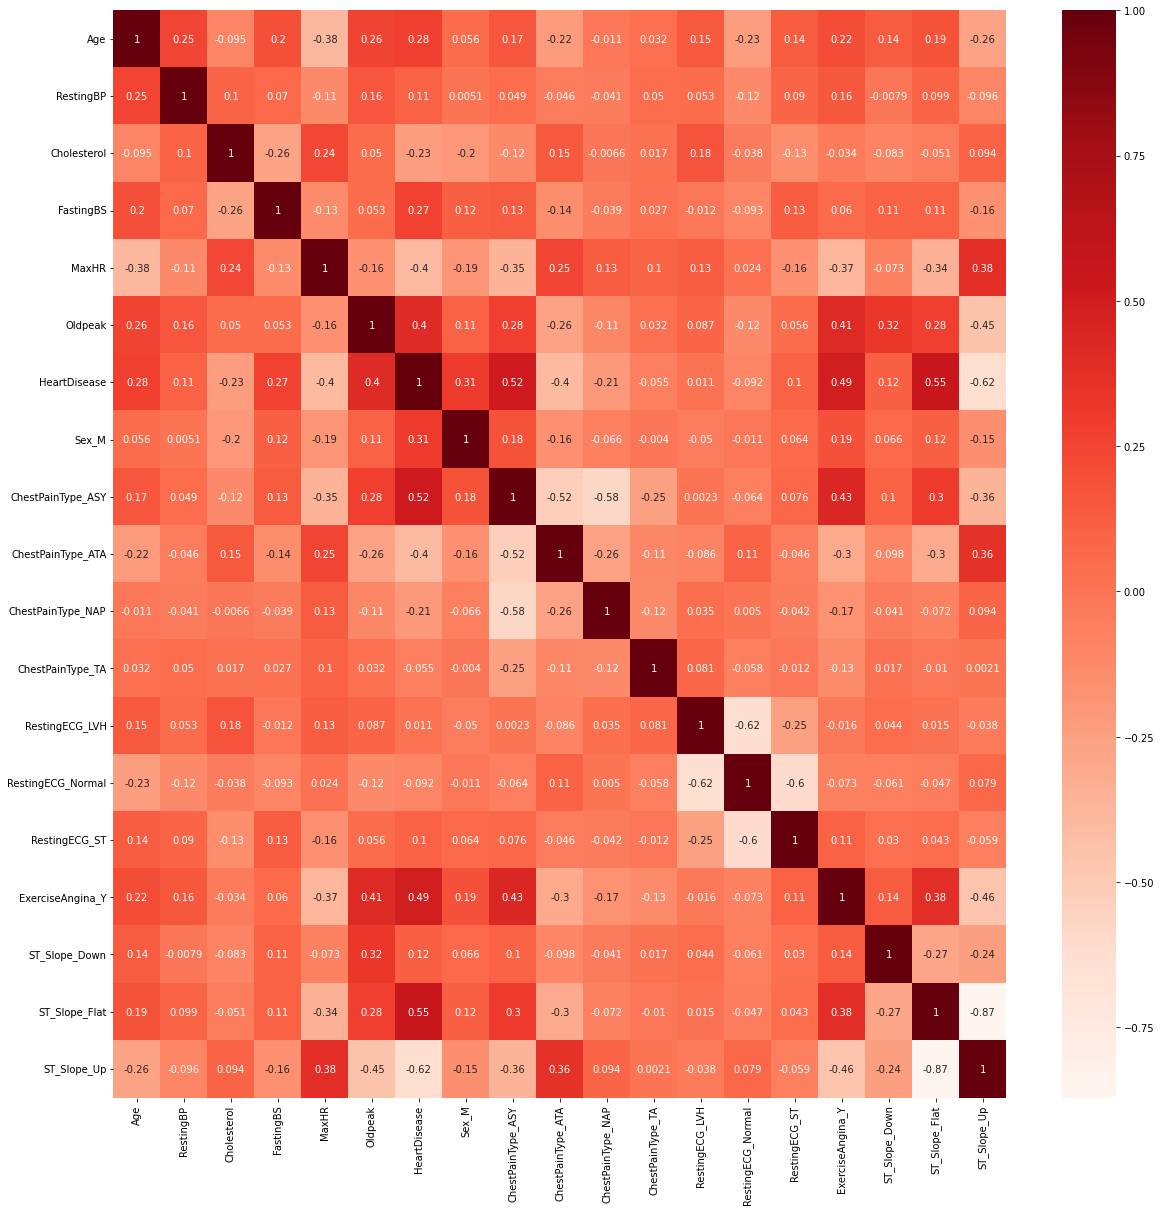

In [48]:
plt.rcParams['figure.figsize'] = 20, 20
sns.heatmap(data.corr(), cmap="Reds", annot=True)

Заметны значительные корреляции целевой переменной от некоторых признаков(`ExerciseAngina`, `ST_Slope`, `ChestPainType`, `Oldpeak`, `Sex`)

## Обучение моделей
### DecisionTreeClassifier
Никакие гиперпараметры трогать не будем, т.е. заведомо получим переобученую модель

In [51]:
y = data['HeartDisease']
X = data.drop('HeartDisease', axis=1)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [105]:
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.68      0.82      0.75        77
           1       0.85      0.73      0.78       107

    accuracy                           0.77       184
   macro avg       0.77      0.77      0.76       184
weighted avg       0.78      0.77      0.77       184



### RandomForestClassifier

In [106]:
model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.77      0.81        77
           1       0.84      0.91      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.84       184
weighted avg       0.85      0.85      0.85       184



Отобразим важность признаков

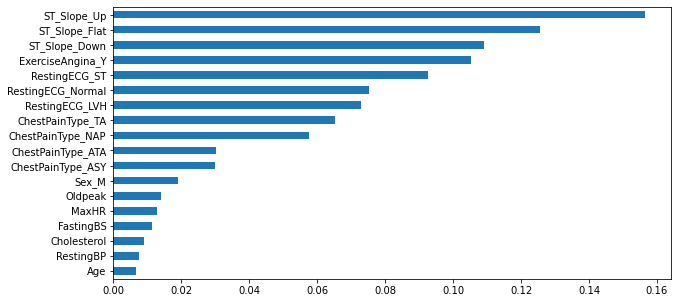

In [89]:
plt.rcParams['figure.figsize'] = 10,5
sorted_idx = model.feature_importances_.argsort()
feat_importances = pd.Series(model.feature_importances_[sorted_idx], index=X.columns)
feat_importances.plot(kind='barh')

### BaggingClassifier

In [107]:
model = BaggingClassifier(base_estimator=RandomForestClassifier(random_state=0))
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        77
           1       0.85      0.91      0.88       107

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



### StackingClassifier

In [108]:
estimators = [
    ('dt', DecisionTreeClassifier(random_state=0)),
     ('rf', RandomForestClassifier(random_state=0)),
     ('svc', make_pipeline(StandardScaler(), LinearSVC(random_state=0)))
]
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.87      0.77      0.81        77
           1       0.84      0.92      0.88       107

    accuracy                           0.85       184
   macro avg       0.86      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



### Выводы
Ансаблирование повышает качество классификации даже без тюнинга гиперпараметров.
Для классифкации болезни сердца лучше подойдет модель с высоким Recall для класса 1 с целью охвата максимального количества больных (TP) с минимальном количеством пропущенных случаев (FN), т.е. StackingClassifier

Итоговые значения метрик (по классу 1)

| Модель                 | accuracy | precision | Recall | F1-score |
|------------------------|----------|-----------|--------|----------|
| StackingClassifier     | 0.85     | 0.84      | 0.92   | 0.88     |
| BaggingClassifier      | 0.85     | 0.85      | 0.91   | 0.88     |
| RandomForestClassifier | 0.91     | 0.84      | 0.91   | 0.88     |
| DecisionTreeClassifier | 0.77     | 0.85      | 0.73   | 0.78     |